In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import numpy as np
import matplotlib.pyplot as plt

import easydict

# Load datasets

In [69]:
import deeplake
dstrain = deeplake.load("hub://activeloop/cifar10-train")
dstest = deeplake.load("hub://activeloop/cifar10-test")

-

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/cifar10-train



\

hub://activeloop/cifar10-train loaded successfully.



Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/cifar10-test



/

hub://activeloop/cifar10-test loaded successfully.



# Define NN

In [70]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(12544, 1024)
        self.fc2 = nn.Linear(1024,128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output


# Train NN

In [71]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        target = data.popitem()[1].squeeze()
        images = data.popitem()[1]
        images, target = images.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            target = data.popitem()[1].squeeze()
            images = data.popitem()[1]
            images, target = images.to(device), target.to(device)
            output = model(images)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [72]:
# Training settings
args = easydict.EasyDict({
    "batch_size": 64,
    "test_batch_size": 10000,
    "train_steps": 1000,
    "no_cuda": False,
    "no_mps": True,
    "seed": 1,
    "lr": 1.0, 
    "gamma": 0.7,
    "epochs": 5,
    "dry_run": False,
    "log_interval": 10,
    "save_model": False
})
use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()

torch.manual_seed(args.seed)

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

tform = transforms.Compose([
    transforms.ToPILImage(), # Must convert to PIL image for subsequent operations to run
    transforms.RandomRotation(20), # Image augmentation
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

#PyTorch Dataloader
train_loader= dstrain.pytorch(batch_size = args.batch_size, num_workers = 1, transform = {'images': tform, 'labels': None}, shuffle = False)
test_loader= dstest.pytorch(batch_size = args.test_batch_size, num_workers = 1, transform = {'images': tform, 'labels': None}, shuffle = False)

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

if args.save_model:
    torch.save(model.state_dict(), "cifar10.pt")


C:\Users\TRBU\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deeplake\integrations\pytorch\common.py:137: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.313285
Train Epoch: 1 [640/50000 (1%)]	Loss: 2.282982
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.208825
Train Epoch: 1 [1920/50000 (4%)]	Loss: 2.134269
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.269092
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.111916
Train Epoch: 1 [3840/50000 (8%)]	Loss: 2.010026
Train Epoch: 1 [4480/50000 (9%)]	Loss: 2.077068
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.052944
Train Epoch: 1 [5760/50000 (12%)]	Loss: 1.960852
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.777685
Train Epoch: 1 [7040/50000 (14%)]	Loss: 1.868737
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.862934
Train Epoch: 1 [8320/50000 (17%)]	Loss: 2.077532
Train Epoch: 1 [8960/50000 (18%)]	Loss: 1.933085
Train Epoch: 1 [9600/50000 (19%)]	Loss: 1.683305
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.063454
Train Epoch: 1 [10880/50000 (22%)]	Loss: 1.725807
Train Epoch: 1 [11520/50000 (23%)]	Loss: 1.506280
Train Epoch: 1 [12160/50000 (24%)]	Loss: 1.459907
Train Epoch: 1 [12800/50000 

# Tests on trained NN

In [73]:
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        pred2 = torch.topk(output, k=2, dim=1)[1][:,1] # index of second largest log-prob
        pred2 = pred2.reshape(pred2.shape[0],1)


## Correct classified vs actual number as a function of ML confidence for max log-prob

In [74]:
## Transform to range [0,1]
output_softmax = torch.softmax(output, dim=1)  
## Select largest entry
selected_entries = torch.gather(output_softmax, 1, pred)

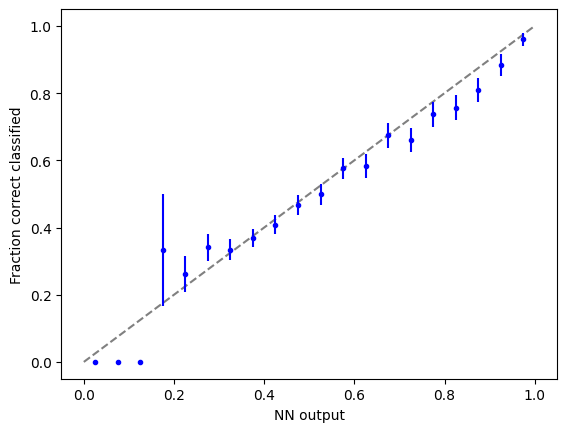

In [75]:
step = 0.05
cat = 1

binMean = []
correctFreq = []
error = []
correct = []
for value in np.arange(0, 1.0, step):
    start = value
    end = start+step

    # Select entries with convidence in interval (start,end]
    conf_in_range = selected_entries[(selected_entries>start) & (selected_entries<=end)]
    pred_in_range = pred[(selected_entries>start) & (selected_entries<=end)]
    targ_in_range = target[[(selected_entries>start)[:,0] & (selected_entries<=end)[:,0]]].squeeze()
    
    binMean.append( start + step/2 )
    correct.append( (pred_in_range == targ_in_range).sum().item() )
    correctFreq.append( (pred_in_range == targ_in_range).sum().item()/targ_in_range.shape[0] if targ_in_range.shape[0]!=0 else 0 )
    error.append( np.sqrt((pred_in_range == targ_in_range).sum().item())/targ_in_range.shape[0] if targ_in_range.shape[0]!=0 else 0 )

plt.plot([0,1], [0,1], '--', color='grey')
plt.errorbar(binMean, correctFreq, error, marker='.', linestyle='', color='blue')
plt.xlabel("NN output")
plt.ylabel("Fraction correct classified")
plt.show()

## Classwise check 

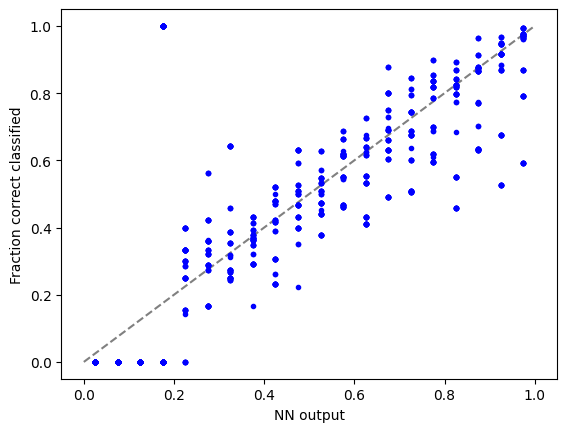

In [78]:
step = 0.05

binMean = []
correctFreq = []
error = []
correct = []

plt.plot([0,1], [0,1], '--', color='grey')
for cat in np.arange(0,10):
    for value in np.arange(0, 1.0, step):
        start = value
        end = start+step

        # Select entries with convidence in interval (start,end]
        conf_in_range = selected_entries[(selected_entries>start) & (selected_entries<=end)]
        pred_in_range = pred[(selected_entries>start) & (selected_entries<=end)]
        targ_in_range = target[[(selected_entries>start)[:,0] & (selected_entries<=end)[:,0]]].squeeze()

        # Confine to only entries with target = cat
        conf_in_range = conf_in_range[targ_in_range==cat]
        pred_in_range = pred_in_range[targ_in_range==cat]
        targ_in_range = targ_in_range[targ_in_range==cat]

        binMean.append( start + step/2 )
        correct.append( (pred_in_range == targ_in_range).sum().item() )
        correctFreq.append( (pred_in_range == targ_in_range).sum().item()/targ_in_range.shape[0] if targ_in_range.shape[0]!=0 else 0 )
        error.append( np.sqrt((pred_in_range == targ_in_range).sum().item())/targ_in_range.shape[0] if targ_in_range.shape[0]!=0 else 0 )
    plt.plot(binMean, correctFreq, marker='.', linestyle='', linewidth=0.1, color='blue')

plt.xlabel("NN output")
plt.ylabel("Fraction correct classified")
plt.show()

TypeError: can only concatenate str (not "int") to str

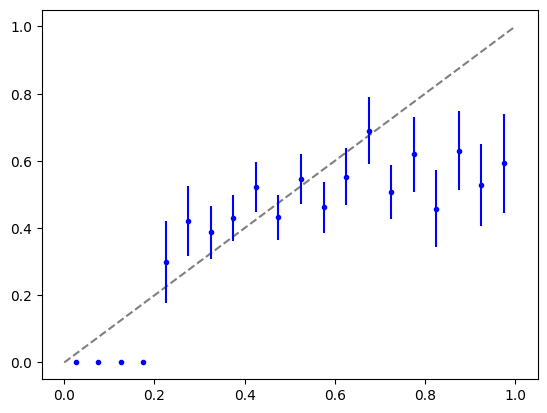

In [90]:
step = 0.05

binMean = []
correctFreq = []
error = []
correct = []

plt.plot([0,1], [0,1], '--', color='grey')
cat = 3

for value in np.arange(0, 1.0, step):
    start = value
    end = start+step

    # Select entries with convidence in interval (start,end]
    conf_in_range = selected_entries[(selected_entries>start) & (selected_entries<=end)]
    pred_in_range = pred[(selected_entries>start) & (selected_entries<=end)]
    targ_in_range = target[[(selected_entries>start)[:,0] & (selected_entries<=end)[:,0]]].squeeze()

    # Confine to only entries with target = cat
    conf_in_range = conf_in_range[targ_in_range==cat]
    pred_in_range = pred_in_range[targ_in_range==cat]
    targ_in_range = targ_in_range[targ_in_range==cat]

    binMean.append( start + step/2 )
    correct.append( (pred_in_range == targ_in_range).sum().item() )
    correctFreq.append( (pred_in_range == targ_in_range).sum().item()/targ_in_range.shape[0] if targ_in_range.shape[0]!=0 else 0 )
    error.append( np.sqrt((pred_in_range == targ_in_range).sum().item())/targ_in_range.shape[0] if targ_in_range.shape[0]!=0 else 0 )

plt.errorbar(binMean, correctFreq, error, marker='.', linestyle='', color='blue')
plt.legend('Only category ' + str(cat) )
plt.xlabel("NN output")
plt.ylabel("Fraction correct classified")
plt.show()